In [ ]:
from pathlib import Path
import sys

# Localizar la raíz del proyecto (carpeta que contiene `src`)
cwd = Path().resolve()
PROJECT_ROOT = None

for parent in [cwd, *cwd.parents]:
    if (parent / "src").is_dir():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError("No se encontró carpeta 'src' en la jerarquía.")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config.settings import (
    PROJECT_ROOT as CFG_PROJECT_ROOT,
    TARGET_COL,
    RANDOM_STATE,
    MODELS_DIR,
)
from src.data.load_data import load_clean_dataset

print("PROJECT_ROOT:", CFG_PROJECT_ROOT)
print("TARGET_COL  :", TARGET_COL)
print("MODELS_DIR  :", MODELS_DIR)


PROJECT_ROOT: D:\Users\dhcertug\OneDrive - Crystal S.A.S\Documentos\HOME\00_PERSONAL\02_CURSOS\PROYECTO\Proyecto_analisis_intermedio_udea\src
TARGET_COL  : Und_2a_percentage
MODELS_DIR  : D:\Users\dhcertug\OneDrive - Crystal S.A.S\Documentos\HOME\00_PERSONAL\02_CURSOS\PROYECTO\Proyecto_analisis_intermedio_udea\src\data\models


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)

from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers import LeakyReLU

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")
sns.set(style="whitegrid")


In [3]:
# Cargar dataset limpio desde la ruta estándar
data = load_clean_dataset()
print("Shape data:", data.shape)

# X e y tal como en el experimento original
cols_to_drop_nn = ["Und_2a_percentage", "total_und", "Und_1a", "Und_2a"]
X = data.drop(cols_to_drop_nn, axis=1)
y = data[TARGET_COL]

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape data: (364832, 27)
Shape X: (364832, 23)
Shape y: (364832,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (291865, 23)
X_test : (72967, 23)
y_train: (291865,)
y_test : (72967,)


In [5]:
# Selección de variables numéricas y categóricas a partir de `data`
numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = data.select_dtypes(include=["object"]).columns.tolist()

# Eliminamos target y columnas derivadas de la parte numérica
for col in ["Und_2a_percentage", "total_und", "Und_1a", "Und_2a"]:
    if col in numerical_features:
        numerical_features.remove(col)

print("Numerical features (NN):", numerical_features)
print("Categorical features (NN):", categorical_features)

preprocessor_nn = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_train_processed = preprocessor_nn.fit_transform(X_train)
X_test_processed = preprocessor_nn.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)


Numerical features (NN): ['semana_anio', 'Tur', 'planta_id', 'seccion_id', 'maq_id', 'Pas', 'producto_id', 'estilo_id', 'Tal', 'Col', 'Tal_Fert', 'Col_Fert', 'Componentes', 'g_art_id', 'mp_id', 'Rechazo_comp', 'rechazo_flag']
Categorical features (NN): ['Tipo_TEJ', 'Tecnologia', 'C', 'categoria_producto', 'MP', 'mp_categoria']
X_train_processed: (291865, 179)
X_test_processed : (72967, 179)


In [6]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

def plot_metrics(history, title_prefix=""):
    metrics = ["mse", "mae"]
    available = [m for m in metrics if m in history.history]

    if not available:
        print("No hay métricas disponibles para graficar.")
        return

    fig, axes = plt.subplots(1, len(available), figsize=(6 * len(available), 4))

    if len(available) == 1:
        axes = [axes]

    for ax, metric in zip(axes, available):
        ax.plot(history.history[metric], label=f"Train {metric.upper()}")
        val_metric = f"val_{metric}"
        if val_metric in history.history:
            ax.plot(history.history[val_metric], label=f"Val {metric.upper()}")

        ax.set_title(f"{title_prefix} {metric.upper()}".strip())
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric.upper())
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


## Modelo 1

In [7]:
input_dim = X_train_processed.shape[1]

model1 = keras.Sequential(
    [
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="linear"),  # regresión
    ]
)

model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,361 (122.50 KB)

 Trainable params: 31,361 (122.50 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento Modelo 1

In [8]:
model1.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mse", "mae", "mape"],
)

history1 = model1.fit(
    X_train_processed,
    y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)


Epoch 1/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0267 - mae: 0.0765 - mape: 19628456.0000 - mse: 0.0267
Epoch 2/50
 107/9121 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0237 - mae: 0.0685 - mape: 16416126.1495 - mse: 0.0237

d:\Users\dhcertug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0227 - mae: 0.0684 - mape: 17444824.0000 - mse: 0.0227
Epoch 3/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0224 - mae: 0.0676 - mape: 17050332.0000 - mse: 0.0224
Epoch 4/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0222 - mae: 0.0671 - mape: 16817720.0000 - mse: 0.0222
Epoch 5/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 0.0220 - mae: 0.0668 - mape: 16656225.0000 - mse: 0.0220
Epoch 6/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0219 - mae: 0.0665 - mape: 16537498.0000 - mse: 0.0219
Epoch 7/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0218 - mae: 0.0664 - mape: 16430318.0000 - mse: 0.0218
Epoch 8/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.0217 - mae: 0.0661 - mape: 16419429.0000 - mse: 0.0217
Epoch 9/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0216 - mae: 0.0659 - mape: 16309279.0000 - mse: 0.0216
Epoch 10/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/

### Evaluación Modelo 1

In [9]:
y_pred1 = model1.predict(X_test_processed).reshape(-1)

r2_1 = r2_score(y_test, y_pred1)
mse_1 = mean_squared_error(y_test, y_pred1)
mae_1 = mean_absolute_error(y_test, y_pred1)

print(f"[Modelo 1] R²  : {r2_1:.4f}")
print(f"[Modelo 1] MSE : {mse_1:.6f}")
print(f"[Modelo 1] MAE : {mae_1:.6f}")


2281/2281 ━━━━━━━━━━━━━━━━━━━━ 2s 861us/step
[Modelo 1] R²  : 0.7917
[Modelo 1] MSE : 0.022676
[Modelo 1] MAE : 0.075149


## Modelo 2

In [10]:
model2 = keras.Sequential(
    [
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),   # capa adicional
        layers.Dropout(0.2),                   # regularización
        layers.Dense(1, activation="linear"),
    ]
)

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,409 (130.50 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento Modelo 2

In [11]:
model2.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mse", "mae", "mape"],
)

history2 = model2.fit(
    X_train_processed,
    y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)


Epoch 1/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0287 - mae: 0.0871 - mape: 21091944.0000 - mse: 0.0287
Epoch 2/50
  71/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0313 - mae: 0.0867 - mape: 18807760.6901 - mse: 0.0313

d:\Users\dhcertug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0251 - mae: 0.0804 - mape: 19000092.0000 - mse: 0.0251
Epoch 3/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0246 - mae: 0.0790 - mape: 18543962.0000 - mse: 0.0246
Epoch 4/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0243 - mae: 0.0785 - mape: 18286636.0000 - mse: 0.0243
Epoch 5/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0242 - mae: 0.0780 - mape: 18045938.0000 - mse: 0.0242
Epoch 6/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0240 - mae: 0.0778 - mape: 17980066.0000 - mse: 0.0240
Epoch 7/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0239 - mae: 0.0775 - mape: 17834412.0000 - mse: 0.0239
Epoch 8/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0238 - mae: 0.0773 - mape: 17777414.0000 - mse: 0.0238
Epoch 9/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0238 - mae: 0.0771 - mape: 17725448.0000 - mse: 0.0238
Epoch 10/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/

### Evaluación Modelo 2

In [12]:
y_pred2 = model2.predict(X_test_processed).reshape(-1)

r2_2 = r2_score(y_test, y_pred2)
mse_2 = mean_squared_error(y_test, y_pred2)
mae_2 = mean_absolute_error(y_test, y_pred2)

print(f"[Modelo 2] R²  : {r2_2:.4f}")
print(f"[Modelo 2] MSE : {mse_2:.6f}")
print(f"[Modelo 2] MAE : {mae_2:.6f}")


2281/2281 ━━━━━━━━━━━━━━━━━━━━ 2s 851us/step
[Modelo 2] R²  : 0.7868
[Modelo 2] MSE : 0.023208
[Modelo 2] MAE : 0.073481


## Modelo 3 (LeakyReLU)

In [13]:
model3 = keras.Sequential(
    [
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation=LeakyReLU(alpha=0.2)),
        layers.Dense(64, activation=LeakyReLU(alpha=0.2)),
        layers.Dense(32, activation=LeakyReLU(alpha=0.2)),
        layers.Dropout(0.2),
        layers.Dense(1, activation="linear"),
    ]
)

model3.summary()


d:\Users\dhcertug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,409 (130.50 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento Modelo 3

In [14]:
model3.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mse", "mae", "mape"],
)

history3 = model3.fit(
    X_train_processed,
    y_train,
    epochs=25,          # igual que el original
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)


Epoch 1/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0332 - mae: 0.0890 - mape: 21825550.0000 - mse: 0.0332
Epoch 2/25
  95/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0302 - mae: 0.0855 - mape: 22395165.0737 - mse: 0.0302

d:\Users\dhcertug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0246 - mae: 0.0784 - mape: 19030852.0000 - mse: 0.0246
Epoch 3/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0240 - mae: 0.0764 - mape: 18391176.0000 - mse: 0.0240
Epoch 4/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0237 - mae: 0.0758 - mape: 18078274.0000 - mse: 0.0237
Epoch 5/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0235 - mae: 0.0753 - mape: 17882612.0000 - mse: 0.0235
Epoch 6/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0234 - mae: 0.0750 - mape: 17736128.0000 - mse: 0.0234
Epoch 7/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0233 - mae: 0.0748 - mape: 17657604.0000 - mse: 0.0233
Epoch 8/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0232 - mae: 0.0747 - mape: 17563264.0000 - mse: 0.0232
Epoch 9/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0232 - mae: 0.0745 - mape: 17467392.0000 - mse: 0.0232
Epoch 10/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/

### Evaluación Modelo 3

In [15]:
y_pred3 = model3.predict(X_test_processed).reshape(-1)

r2_3 = r2_score(y_test, y_pred3)
mse_3 = mean_squared_error(y_test, y_pred3)
mae_3 = mean_absolute_error(y_test, y_pred3)

print(f"[Modelo 3] R²  : {r2_3:.4f}")
print(f"[Modelo 3] MSE : {mse_3:.6f}")
print(f"[Modelo 3] MAE : {mae_3:.6f}")


2281/2281 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step
[Modelo 3] R²  : 0.7960
[Modelo 3] MSE : 0.022206
[Modelo 3] MAE : 0.066819


## Curvas de entrenamiento

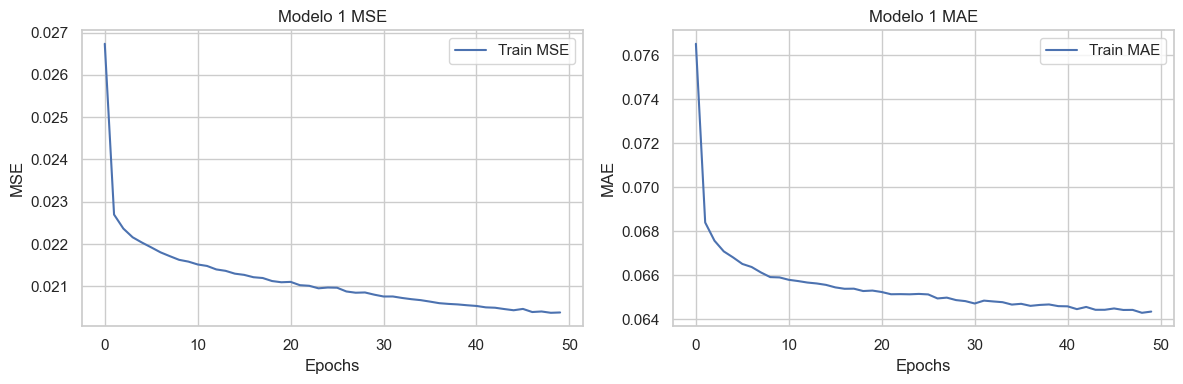

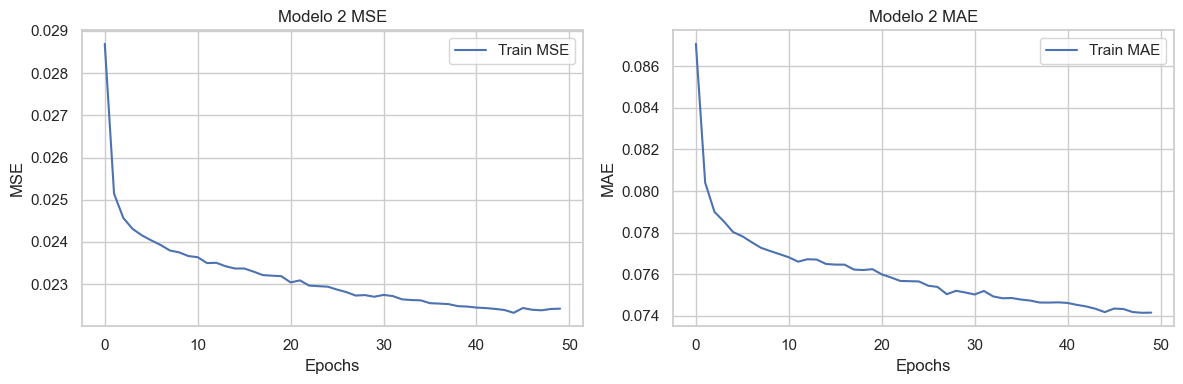

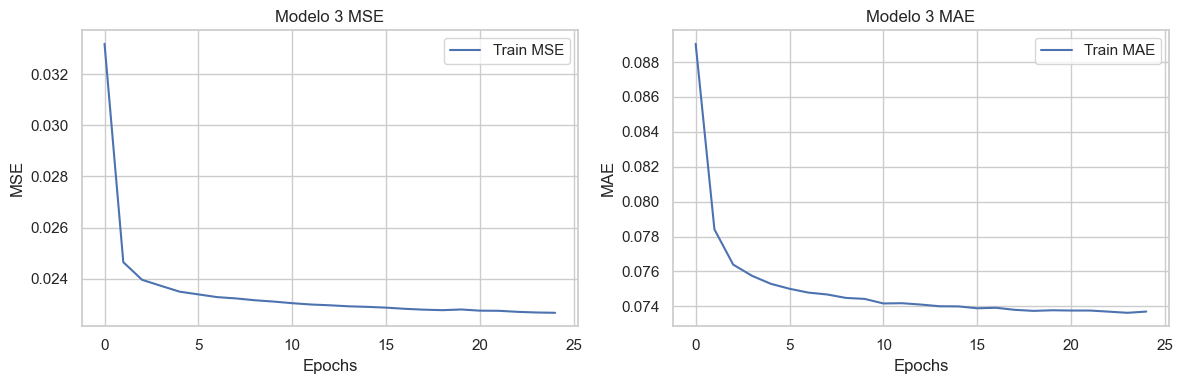

In [16]:
plot_metrics(history1, title_prefix="Modelo 1")
plot_metrics(history2, title_prefix="Modelo 2")
plot_metrics(history3, title_prefix="Modelo 3")


## Modelo 4: XGBoost

In [17]:
# Volvemos a usar X tal como fue definido para los modelos NN (mismas columnas)
num_features_xgb = X.select_dtypes(include=["int64", "float64"]).columns
cat_features_xgb = X.select_dtypes(include=["object"]).columns

print("Numeric features (XGB):", list(num_features_xgb))
print("Categorical features (XGB):", list(cat_features_xgb))

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features_xgb),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features_xgb),
    ]
)


Numeric features (XGB): ['semana_anio', 'Tur', 'planta_id', 'seccion_id', 'maq_id', 'Pas', 'producto_id', 'estilo_id', 'Tal', 'Col', 'Tal_Fert', 'Col_Fert', 'Componentes', 'g_art_id', 'mp_id', 'Rechazo_comp', 'rechazo_flag']
Categorical features (XGB): ['Tipo_TEJ', 'Tecnologia', 'C', 'categoria_producto', 'MP', 'mp_categoria']


In [18]:
xgb_model = XGBRegressor(
    n_estimators=700,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.3,
    reg_lambda=1.5,
    random_state=42,
    objective="reg:squarederror",
    n_jobs=-1,
)

pipeline_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor_xgb),
        ("model", xgb_model),
    ]
)


In [19]:
# Ordenar por semana y hacer split temporal 80/20
df_sorted = data.sort_values("semana_anio")

split_week = df_sorted["semana_anio"].quantile(0.8)

train_df = df_sorted[df_sorted["semana_anio"] <= split_week]
test_df  = df_sorted[df_sorted["semana_anio"] >  split_week]

X_train_xgb = train_df.drop("Und_2a_percentage", axis=1)
y_train_xgb = train_df["Und_2a_percentage"]

X_test_xgb = test_df.drop("Und_2a_percentage", axis=1)
y_test_xgb = test_df["Und_2a_percentage"]

print("X_train_xgb:", X_train_xgb.shape)
print("X_test_xgb :", X_test_xgb.shape)

# Filtrado de outliers en la variable objetivo
q_low  = y_train_xgb.quantile(0.01)
q_high = y_train_xgb.quantile(0.99)
mask = (y_train_xgb >= q_low) & (y_train_xgb <= q_high)

X_train_xgb = X_train_xgb[mask]
y_train_xgb = y_train_xgb[mask]

print("X_train_xgb (filtrado):", X_train_xgb.shape)


X_train_xgb: (296717, 26)
X_test_xgb : (68115, 26)
X_train_xgb (filtrado): (296717, 26)


### Entrenar XGBoost y evaluar

In [20]:
pipeline_xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = pipeline_xgb.predict(X_test_xgb)

mae_xgb  = mean_absolute_error(y_test_xgb, y_pred_xgb)
mse_xgb  = mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb   = r2_score(y_test_xgb, y_pred_xgb)

print(f"[XGB] MAE : {mae_xgb:.6f}")
print(f"[XGB] RMSE: {rmse_xgb:.6f}")
print(f"[XGB] MSE : {mse_xgb:.6f}")
print(f"[XGB] R²  : {r2_xgb:.4f}")


[XGB] MAE : 0.069951
[XGB] RMSE: 0.148136
[XGB] MSE : 0.021944
[XGB] R²  : 0.7923


In [21]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)

xgb_experiment_path = MODELS_DIR / "modelo_xgb_und2a_04_experimentos.pkl"
joblib.dump(pipeline_xgb, xgb_experiment_path)

xgb_experiment_path


WindowsPath('D:/Users/dhcertug/OneDrive - Crystal S.A.S/Documentos/HOME/00_PERSONAL/02_CURSOS/PROYECTO/Proyecto_analisis_intermedio_udea/src/data/models/modelo_xgb_und2a_04_experimentos.pkl')

In [22]:
summary = pd.DataFrame(
    {
        "modelo": ["NN1", "NN2", "NN3", "XGB"],
        "R2":     [r2_1, r2_2, r2_3, r2_xgb],
        "MSE":    [mse_1, mse_2, mse_3, mse_xgb],
        "MAE":    [mae_1, mae_2, mae_3, mae_xgb],
    }
)

summary


,modelo,R2,MSE,MAE
0,NN1,0.791696,0.022676,0.075149
1,NN2,0.786811,0.023208,0.073481
2,NN3,0.796013,0.022206,0.066819
3,XGB,0.792339,0.021944,0.069951
